In [1]:
import pandas as pd
import math as m
from IPython.display import display as disp
import lablib as ll
%matplotlib inline

Загружаем данные, приводим к СИ. Время будем рассматривать в мкс, а напряжения в мВ, чтобы не терять точность.

In [2]:
data, columns, experiments = ll.read_standard_layout()

e = "main"

ll.compute(name = "T",
           expr = lambda T: T + 273,
           data = data[e],
           columns = columns[e])

disp(data[e], columns[e])

,Value,Error,ErrorRel
t_0,6.956400,0.000100,0.00%
_dT_dU,24.000000,0.500000,2.08%


,T,Error_T,ErrorRel_T,U,Error_U,ErrorRel_U,t,Error_t,ErrorRel_t
0,290.770000,0.010000,0.00%,-0.002000,0.001200,-60.00%,7.828600,0.000100,0.00%
1,291.030000,0.010000,0.00%,-0.004000,0.001200,-30.00%,7.811500,0.000100,0.00%
2,293.060000,0.010000,0.00%,-0.017000,0.001200,-7.06%,7.650000,0.000100,0.00%
3,295.080000,0.010000,0.00%,-0.017000,0.001200,-7.06%,7.440000,0.000100,0.00%
4,298.080000,0.010000,0.00%,-0.015000,0.001200,-8.00%,7.212000,0.000100,0.00%
5,303.080000,0.010000,0.00%,-0.013000,0.001200,-9.23%,7.108500,0.000100,0.00%
6,308.060000,0.010000,0.00%,-0.015000,0.001200,-8.00%,7.072000,0.000100,0.00%
7,313.050000,0.010000,0.00%,-0.012000,0.001200,-10.00%,7.053500,0.000100,0.00%


Корректируем температуру согласно показаниям с термопары:

$T_{образца} = T_{воды} + \Delta U * \frac{dT}{dU}_{термопары}$


In [3]:
ll.compute(name = "T",
           expr = lambda T, U, _dT_dU: T + U * _dT_dU,
           data = data[e],
           columns = columns[e])
    
disp(data[e], columns[e])

,Value,Error,ErrorRel
t_0,6.956400,0.000100,0.00%
_dT_dU,24.000000,0.500000,2.08%


,T,Error_T,ErrorRel_T,U,Error_U,ErrorRel_U,t,Error_t,ErrorRel_t
0,290.722000,0.030503,0.01%,-0.002000,0.001200,-60.00%,7.828600,0.000100,0.00%
1,290.934000,0.030552,0.01%,-0.004000,0.001200,-30.00%,7.811500,0.000100,0.00%
2,292.652000,0.031649,0.01%,-0.017000,0.001200,-7.06%,7.650000,0.000100,0.00%
3,294.672000,0.031649,0.01%,-0.017000,0.001200,-7.06%,7.440000,0.000100,0.00%
4,297.720000,0.031396,0.01%,-0.015000,0.001200,-8.00%,7.212000,0.000100,0.00%
5,302.768000,0.031172,0.01%,-0.013000,0.001200,-9.23%,7.108500,0.000100,0.00%
6,307.700000,0.031396,0.01%,-0.015000,0.001200,-8.00%,7.072000,0.000100,0.00%
7,312.762000,0.031072,0.01%,-0.012000,0.001200,-10.00%,7.053500,0.000100,0.00%


Вычислим промежуточные данные $(\tau^2 - \tau_0^2) \propto \chi \propto \frac{1}{T - \Theta_p}$ и построим график $(\tau^2 - \tau_0^2) = f(T)$.

Заодно приблизим теоретической кривой $f(T) \propto \frac{1}{T - \Theta_p}$, получая для неё результат в $\Theta_p = 290 \pm 0.6 °K$.

Initial guesses for tsq_minus_t0sq = f(T):
               Value    Error  ErrorRel
k_1        32.355010 0.015635  0.000483
theta_p_1 289.516364 0.001800  0.000006

Final guesses for tsq_minus_t0sq = f(T):


,Value,Error,ErrorRel
k_1,29.579607,1.388683,4.69%
theta_p_1,289.781957,0.562389,0.19%


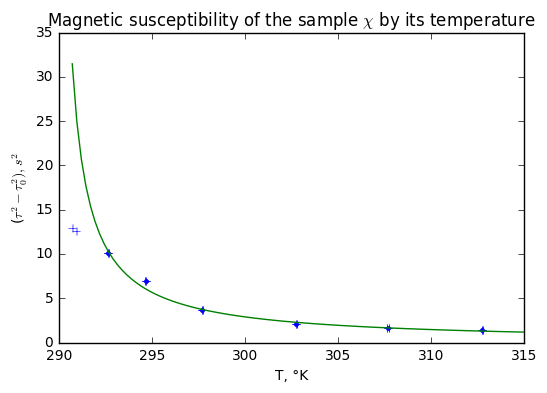

In [4]:
ll.compute(name = "tsq_minus_t0sq",
           expr = lambda t, t_0: t**2 - t_0**2,
           data = data[e],
           columns = columns[e])

ll.plotfit(title = "Magnetic susceptibility of the sample $\\chi$ by its temperature",
           xlabel = "T, °K",
           ylabel = "($\\tau^2 - \\tau_0^2), s^2$",
           model = lambda T, k_1, theta_p_1: k_1 / (T - theta_p_1),
           x = "T", y = "tsq_minus_t0sq",
           columns = columns[e],
           fit_columns = columns[e][2:],
           data = data[e])
None

Таким же способом построим график $\frac{1}{\tau^2 - \tau_0^2} = f(T)$ и приблизим его прямой $f(T) \propto T - \Theta_p$.

Для этого метода получен тот же самый результат в $\Theta_p = 290 \pm 0.6 °K$.

Initial guesses for _1_tsq_minus_t0sq = f(T):
               Value    Error  ErrorRel
k_2         0.029221 0.000016  0.000540
theta_p_2 289.342438 0.002135  0.000007

Final guesses for _1_tsq_minus_t0sq = f(T):


,Value,Error,ErrorRel
k_2,0.033754,0.001578,4.68%
theta_p_2,289.772487,0.564096,0.19%


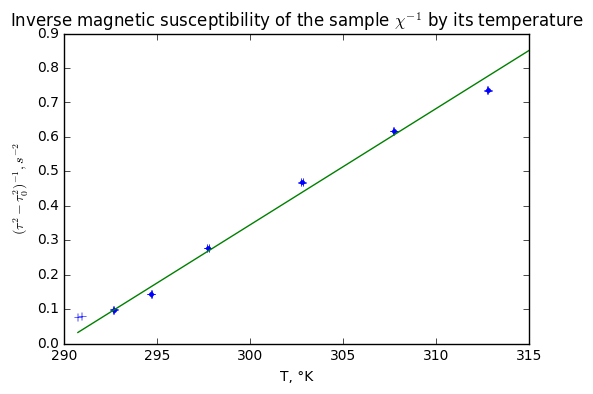

In [6]:
ll.compute(name = "_1_tsq_minus_t0sq",
           expr = lambda t, t_0: 1 / (t**2 - t_0**2),
           data = data[e],
           columns = columns[e])

ll.plotfit(title = "Inverse magnetic susceptibility of the sample $\\chi^{-1}$ by its temperature",
           xlabel = "T, °K", ylabel = "$(\\tau^2 - \\tau_0^2)^{-1}, s^{-2}$",
           model = lambda T, k_2, theta_p_2: k_2 * (T - theta_p_2),
           x = "T",
           y = "_1_tsq_minus_t0sq",
           columns = columns[e],
           fit_columns = columns[e][2:],
           data = data[e],
           axis = [None, None, 0, None])
None